In [1]:
%run Functions.ipynb
%matplotlib inline
import numpy as np

# Loading and preparing the data

## Preparing the relations

In [2]:
data = np.loadtxt('data/user_taggedartists-timestamps.dat',skiprows=1)#, dtype=int)
print("The original data consists of %d tuples (userID, itemID, tagID)." % data.shape[0])
unique = np.unique(data[:,0])
print("%d users" % len(unique))
unique = np.unique(data[:,1])
print("%d items" % len(unique))
unique = np.unique(data[:,2])
print("%d tags" % len(unique))

The original data consists of 186479 tuples (userID, bookmarkID, tagID).
1892 users
12523 items
9749 tags


## Sampling
If the data set is too big, we can sample the data by selecting only the $size$ most used items and tags.

In [3]:
size = 100

# Count number of occurencies, set limit 
unique, counts = np.unique(data[:,1], return_counts=True)
lim = sorted(counts, reverse=True)[size]
unique_items = unique[counts>=lim]
data_smpl = data[np.isin(data[:,1], unique_items)]
print("By choosing top %d most used items we obtain %d samples." % (len(unique_items),data_smpl.shape[0]))

unique, counts = np.unique(data_smpl[:,2], return_counts=True)
lim = sorted(counts, reverse=True)[size]
unique_tags = unique[counts>=lim]
data_smpl = data_smpl[np.isin(data_smpl[:,2], unique_tags)]
print("By choosing top %d most used tags we obtain %d samples." % (len(unique_tags),data_smpl.shape[0]))
data = data_smpl

By choosing top 101 most used items we obtain 29532 samples.
By choosing top 102 most used tags we obtain 20936 samples.


## Preparing the relations

In [4]:
# For each pair of userID, itemID list all the tagIDs used, also save timestamp
pairs = defaultdict(list)
for entry in data:
    pair = entry[0], entry[1], entry[3]
    pairs[pair].append(entry[2])
    
entries = list(pairs.keys())

# Sort by timestamp
a = np.array(entries)
entries = a[a[:,-1].argsort()]

Split entries into training (75%) and test (25%) sets.

In [5]:
train_set = entries[:int(len(entries) * 0.75)]
test_set = entries[int(len(entries) * 0.75):]
print(len(train_set))
print(len(test_set))

6911
2304


We present the data as three relations: $R_{user, item}$, $R_{user, tag}$, $R_{item, tag}$

In [6]:
unique_users = list(np.unique(data[:,0]))
unique_items = list(np.unique(data[:,1]))
unique_tags = list(np.unique(data[:,2]))

print("%d users" % len(unique_users))
print("%d items" % len(unique_items))
print("%d tags" % len(unique_tags))

user_item = np.zeros((len(unique_users), len(unique_items)))
user_tag = np.zeros((len(unique_users), len(unique_tags)))
item_tag = np.zeros((len(unique_items), len(unique_tags)))

i = 0
for a in train_set:
    user_item[unique_users.index(a[0]), unique_items.index(a[1])] = 1
    for entry in pairs[(a[0], a[1], a[2])]:
        user_tag[unique_users.index(a[0]), unique_tags.index(entry)] += 1
        item_tag[unique_items.index(a[1]), unique_tags.index(entry)] += 1

1064 users
101 items
102 tags


Sparseness of matrices

In [7]:
dim = user_item.shape
print ((user_item > 0).sum() / user_item.size)

dim = user_tag.shape
print ((user_tag > 0).sum() / user_tag.size)

dim = item_tag.shape
print ((item_tag > 0).sum() / item_tag.size)

0.0531619891312
0.0553681999115
0.29440885265


# Recommendation

In [8]:
#random matrix used as baseline
sizeU, sizeI = user_item.shape
random_matrix = np.random.rand(sizeU, sizeI)

In [9]:
predicted = user_tag.dot(item_tag.T)
paths = ((user_tag > 0)*1).dot(((item_tag.T>0)*1))
pred_normalized = normalize(predicted, paths)

print("Baseline: ", recall(evaluate(random_matrix, test_set), 20))

print("Multiplication: ", recall(evaluate(predicted*1., test_set), 20))
print("Paths: ", recall(evaluate(paths*1., test_set), 20))
print("Normalized: ", recall(evaluate(pred_normalized, test_set), 20))

Baseline:  0.183159722222
Multiplication:  0.143229166667
Paths:  0.0798611111111
Normalized:  0.114583333333


## Pareto
We can use both predicted value and number of paths together to get the pareto frontier.

In [10]:
print("Pareto: ", recall(evaluate(predicted, test_set, paths), 20))

Pareto:  0.146267361111


# DFMF
Using DFMF we can fill the rest of the matrices and use the new data to make predictions.

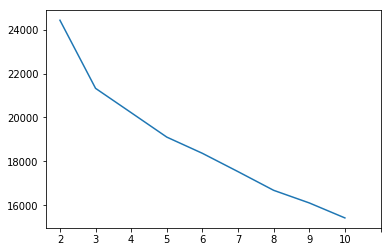

In [11]:
errors = []
n = 1
for i in np.arange(2, 11, 1):
    run_sum = 0
    for _ in range(n):
        G, S = dfmf(i, user_item, user_tag, item_tag)
        G_users, G_items, G_tags = G
        S_user_tag, S_tag_item, S_user_item = S

        err1 = np.ma.masked_equal(user_item, 0) - G_users.dot(S_user_item.dot(G_items.T))
        err1 = np.sqrt(err1**2).sum()
        err2 = np.ma.masked_equal(user_tag, 0) - G_users.dot(S_user_tag.dot(G_tags.T))
        err2 = np.sqrt(err2**2).sum()
        err3 = np.ma.masked_equal(item_tag.T, 0) - G_tags.dot(S_tag_item.dot(G_items.T))
        err3 = np.sqrt(err3**2).sum()
        run_sum += err1 + err2 + err3
    errors.append(run_sum/n)

ticks = np.arange(2, 11, 1)
locs = np.arange(0, 10)
plt.plot(errors)
plt.xticks(locs)
plt.gca().set_xticklabels(ticks);

We can use factor matrices to approximate the original data.

In [12]:
G, S = dfmf(3, user_item, user_tag, item_tag)
G_users, G_items, G_tags = G
S_user_tag, S_tag_item, S_user_item = S

pred_dfmf = G_users.dot(S_user_item.dot(G_items.T))

print("Baseline: ", recall(evaluate(random_matrix, test_set), 20))
print("DFMF: ", recall(evaluate(pred_dfmf, test_set), 20))

Baseline:  0.183159722222
DFMF:  0.213107638889


Since we only know where users added (liked), but not "not added" (disliked), DFMF takes a masked matrix with only 1s visible and tries to fill the new matrix with values close to 1. We can see this in the histogram below. It doesn't help us with recommendation.

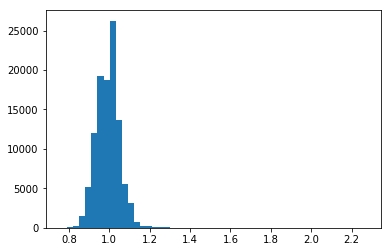

In [13]:
plt.hist(pred_dfmf.flatten(), bins=50);

But we can also approximate the other two matrices and chain them to obtain new predictions.

Chain GSSG:  0.137586805556
Chain:  0.276909722222


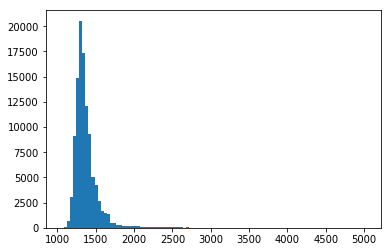

In [14]:
chain_dfmf = G_users.dot(S_user_tag.dot(S_tag_item.dot(G_items.T)))
print("Chain GSSG: ", recall(evaluate(chain_dfmf, test_set), 20))

chain_dfmf = G_users.dot(S_user_tag.dot(G_tags.T.dot(G_tags.dot(S_tag_item.dot(G_items.T)))))
plt.hist(chain_dfmf.flatten(), bins=100);
print("Chain: ", recall(evaluate(chain_dfmf, test_set), 20))

We can now see that the values of the predictions are more diverse.

## Paths with threshold

Since DFMF returns full matrices, we can not just count the number of connections, since all objects are connected. Instead we decide to filter these connections as more or less relevant / strong. We will try this first by setting a global filter and then by setting local filters for each element.

In [15]:
b = G_users.dot(S_user_tag.dot(G_tags.T))
d = G_tags.dot(S_tag_item.dot(G_items.T))

Maximum paths:  0.270399305556 , with filters:  [5, 90]
Maximum filtered values:  0.295138888889 , with filters:  [5, 90]
Maximum pareto:  0.287760416667 , with filters:  [10, 30]
Maximum pareto on filtered:  0.289930555556 , with filters:  [5, 90]


(0.27039930555555558,
 0.2951388888888889,
 0.28776041666666669,
 0.28993055555555558)

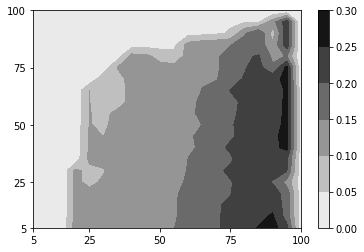

In [16]:
matrixFilter(b, d)

Maximum paths:  0.131076388889 , with filters:  [80, 85]
Maximum filtered values:  0.288194444444 , with filters:  [5, 30]
Maximum pareto:  0.281684027778 , with filters:  [45, 5]
Maximum pareto on filtered:  0.265625 , with filters:  [45, 90]


(0.1310763888888889, 0.28819444444444442, 0.28168402777777779, 0.265625)

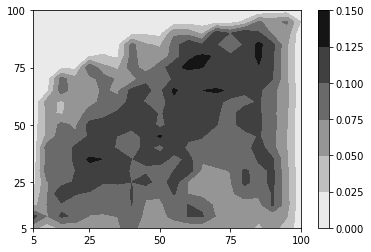

In [17]:
rowFilter(b, d)

## Cross-validation

In [18]:
from sklearn.model_selection import KFold

result = defaultdict(list)
result2 = defaultdict(list)

kf = KFold(n_splits=4)
for train, test in kf.split(train_set):
    X_train, X_test = np.array(train_set)[train], np.array(train_set)[test]

    user_item = np.zeros((len(unique_users), len(unique_items)))
    user_tag = np.zeros((len(unique_users), len(unique_tags)))
    item_tag = np.zeros((len(unique_items), len(unique_tags)))

    i = 0
    for a in X_train:
        user_item[unique_users.index(a[0]), unique_items.index(a[1])] = 1
        for entry in pairs[(a[0], a[1], a[2])]:
            user_tag[unique_users.index(a[0]), unique_tags.index(entry)] += 1
            item_tag[unique_items.index(a[1]), unique_tags.index(entry)] += 1            
            
    G, S = dfmf(3, user_item, user_tag, item_tag)
    G_users, G_items, G_tags = G
    S_user_tag, S_tag_item, S_user_item = S
    
    b = G_users.dot(S_user_tag.dot(G_tags.T))
    d = G_tags.dot(S_tag_item.dot(G_items.T))

    for m in range(5,101,5):
        for n in range(5,101,5):
            b_u_p = importantCells(b, m)

            d_u_p = importantCells(d, n)

            r = b_u_p.dot(d_u_p)
            res = recall(evaluate(r, X_test), 20)
            result[m,n].append(res)
            
    for m in range(5,101,5):
        for n in range(5,101,5):        
            b_u_p = importantCells2(b, m)
            d_u_p = importantCells2(d, n, axis=0)

            r = b_u_p.dot(d_u_p)
            res = recall(evaluate(r, X_test), 20)
            result2[m,n].append(res)

In [19]:
maximum = 0
para = [0,0]

for key in result:
    score = np.mean(result[key])
    if score > maximum:
        maximum = score
        para = key
print(maximum, para)

0.231076858018 (5, 85)


In [20]:
maximum = 0
para = [0,0]

for key in result2:
    score = np.mean(result2[key])
    if score > maximum:
        maximum = score
        para = key
print(maximum, para)

0.142815579495 (45, 45)


# Chain matrix factorization

By using matrix factorization it is possible to predict the value of elements missing in the data.
We can speed up calculations by choosing an appropraite multiplication order.

In [21]:
users = len(unique_users)
items = len(unique_items)
tags = len(unique_tags)

R = np.vstack((
    np.hstack((np.zeros((users, users)), user_item, user_tag)),
    np.hstack((np.zeros((items, users)), np.zeros((items, items)), item_tag)),
    np.hstack((np.zeros((tags, users)), np.zeros((tags, items)), np.zeros((tags, tags)))),
    ))

Obtaining $S$ and $G$ from the model

In [22]:
users, items = S_user_item.shape
tags = S_tag_item.shape[0]

S = np.vstack((
    np.hstack((np.zeros((users, users)), S_user_item, S_user_tag)),
    np.hstack((np.zeros((items, users)), np.zeros((items, items)), S_tag_item.T)),
    np.hstack((np.zeros((tags, users)), np.zeros((tags, items)), np.zeros((tags, tags)))),
    ))

G = scipy.linalg.block_diag(G_users, G_items, G_tags)

We measure the average time of various chaining methods and how they compare to $R^2$.

In [23]:
import time
time_R2 = []
time_GS2G = []
time_K = []
time_GSG2 = []
time_GSGGSG = []

for _ in range(100):
    start = time.time()
    R.dot(R)
    end = time.time()
    time_R2.append(end-start)    

    start = time.time()
    G.dot(S).dot(S).dot(G.T)
    end = time.time()
    time_GS2G.append(end-start)
    
    start = time.time()
    K = G.T.dot(G).dot(S)
    G.dot(S).dot(np.linalg.matrix_power(K, 1)).dot(G.T)
    end = time.time()
    time_K.append(end-start)

    start = time.time()
    np.linalg.matrix_power(G.dot(S).dot(G.T), 2)
    end = time.time()
    time_GSG2.append(end-start)
    
    start = time.time()
    G.dot(S).dot(G.T).dot(G).dot(S).dot(G.T)
    end = time.time()
    time_GSGGSG.append(end-start)

print("R²: \t%.4f" % np.mean(time_R2))
print("GS²G: \t%.4f" % np.mean(time_GS2G))
print("GSGGSG: %.4f" % np.mean(time_GSGGSG))
print("(GSG)²: %.4f" % np.mean(time_GSG2))
print("GSKG: \t%.4f" % np.mean(time_K))

print("Speedup:")
print("R²: \t%.4f" % (np.mean(time_R2)/np.mean(time_R2)))
print("GS²G: \t%.4f" % (np.mean(time_R2)/np.mean(time_GS2G)))
print("GSGGSG: %.4f" % (np.mean(time_R2)/np.mean(time_GSGGSG)))
print("(GSG)²: %.4f" % (np.mean(time_R2)/np.mean(time_GSG2)))
print("GSKG: \t%.4f" % (np.mean(time_R2)/np.mean(time_K)))

R²: 	0.0792
GS²G: 	0.0329
GSGGSG: 0.0687
(GSG)²: 0.1141
GSKG: 	0.0324
Speedup:
R²: 	1.0000
GS²G: 	2.4079
GSGGSG: 1.1529
(GSG)²: 0.6941
GSKG: 	2.4457
